In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow,tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import monai
from monai.data import (
    create_test_image_2d, 
    pad_list_data_collate, 
    list_data_collate, 
    decollate_batch, 
    DataLoader
)
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    RandAffined,
    Rand2DElasticd,
    NormalizeIntensityd,
    ResizeWithPadOrCropd,
    Lambda,
    SpacingD
)
from monai.visualize import plot_2d_or_3d_image

import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import json



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
print(device)

cuda:0


In [4]:
from pathlib import Path
working_dir = Path.cwd()

data_path = working_dir / 'data_axondeepseg_sem'
images = sorted(data_path.rglob("*_SEM.png"))
ax_labels = sorted(data_path.rglob("*_SEM_seg-axon-manual.png"))
my_labels = sorted(data_path.rglob("*_SEM_seg-myelin-manual.png"))
train, val, test = [], [], []

# manually selecting samples to reproduce default SEM model training config
for example in zip(images, ax_labels, my_labels):
    fname = str(example[0])
    
    # add pixel size to have them inside the data dict
    metadata_fname = example[0].parent.glob("*.json")
    with open(next(metadata_fname)) as metadata_f:
        metadata = json.load(metadata_f)
        im, ax, my = example
        # isotropic pixel size: we can keep only one value
        px_size = metadata['PixelSize'][0]
        example = (im, ax, my, px_size)

    if 'sub-rat6' in fname:
        test.append(example)
    elif 'sub-rat1' in fname or 'sub-rat5' in fname:
        val.append(example)
    else:
        train.append(example)

# data dicts for train/val/test splits
train_files = [{"im": str(img), "seg-ax": str(ax), "seg-my": str(my), "px_size": px} for (img, ax, my, px) in train]
val_files = [{"im": str(img), "seg-ax": str(ax), "seg-my": str(my), "px_size": px} for (img, ax, my, px) in val]
test_files = [{"im": str(img), "seg-ax": str(ax), "seg-my": str(my), "px_size": px} for (img, ax, my, px) in test]

## Resampling
We will now test if the resampling works as expected. `SpacingD` is the transform used to apply the resampling operation. We want to resample the images to a common pixel size of 0.1 um/px. For NIFTI input, the spatial voxel size is embedded in the `affine` metadata. For our 2D PNG images, we need to add this manually to the metadata of the `MetaTensor` object. This will be done using the following custom transform.

In [5]:
class AssignPixelSize:
    def __init__(self, keys, px_size_key):
        self.keys = keys
        self.px_size_key = px_size_key

    def __call__(self, data_dict):
        print(data_dict[self.px_size_key])
        for k in self.keys:
            data_dict[k].affine[0, 0] = data_dict[self.px_size_key]
            data_dict[k].affine[1, 1] = data_dict[self.px_size_key]
        return data_dict

In [6]:
t_resample = Compose(
    [
        LoadImaged(keys=["im", "seg-ax", "seg-my"]),
        EnsureChannelFirstd(keys=["im", "seg-ax", "seg-my"]),
        Lambda(func=AssignPixelSize(keys=["im", "seg-ax", "seg-my"], px_size_key="px_size")),
        SpacingD(
            keys=["im", "seg-ax", "seg-my"], 
            pixdim=(0.1, 0.1),
            mode=("bilinear", "nearest", "nearest"),
        ),
    ]
)

t_no_resample = Compose(
    [
        LoadImaged(keys=["im", "seg-ax", "seg-my"]),
        EnsureChannelFirstd(keys=["im", "seg-ax", "seg-my"]),
    ]
)

### No resampling
For a baseline, let's visualize without the resampling

First patch with no resampling
torch.Size([4, 1, 256, 256])


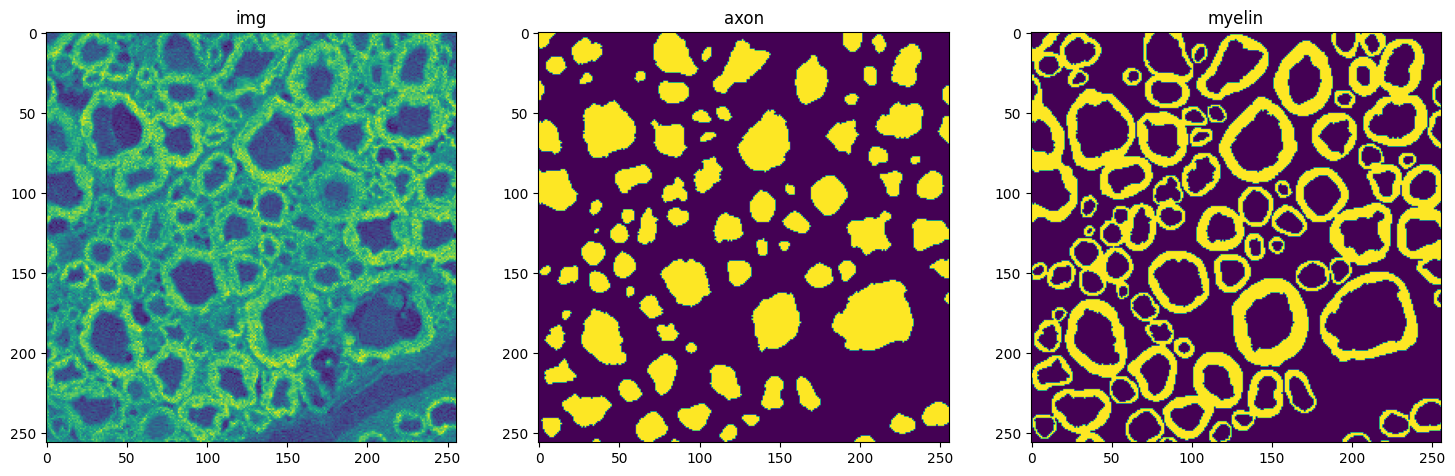

In [7]:
check_data = monai.data.Dataset(data=val_files, transform=t_no_resample)

patch_iterator = monai.data.PatchIterd(keys=["im", "seg-ax", "seg-my"], patch_size=(256, 256), mode='constant')
bs = 4
# need num_worker=0 in dataloader for GPU
nw = 0

check_ds = monai.data.GridPatchDataset(data=check_data, patch_iter=patch_iterator)
check_loader = DataLoader(check_ds, batch_size=bs, num_workers=nw, collate_fn=list_data_collate)

print("First patch with no resampling")
for batch in check_loader:
    stuff = batch[0]
    print(stuff["im"].shape)
    for i in range(stuff["im"].shape[0]):
        plt.figure("alignment check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("img")
        plt.imshow(stuff["im"][i][0])
        plt.subplot(1, 3, 2)
        plt.title("axon")
        plt.imshow(stuff["seg-ax"][i][0])
        plt.subplot(1, 3, 3)
        plt.title("myelin")
        plt.imshow(stuff["seg-my"][i][0])
        plt.show()
        break
    break

### With resampling
Let's visualize the same 4 examples with resampling. As we will see, the image is "zoomed" with a factor approximately equal to 2. This is what we expect because the image loaded has pixel size 0.18 um/px and we resample it to 0.1 um/px.

First patch with resampling
0.18
torch.Size([4, 1, 256, 256])


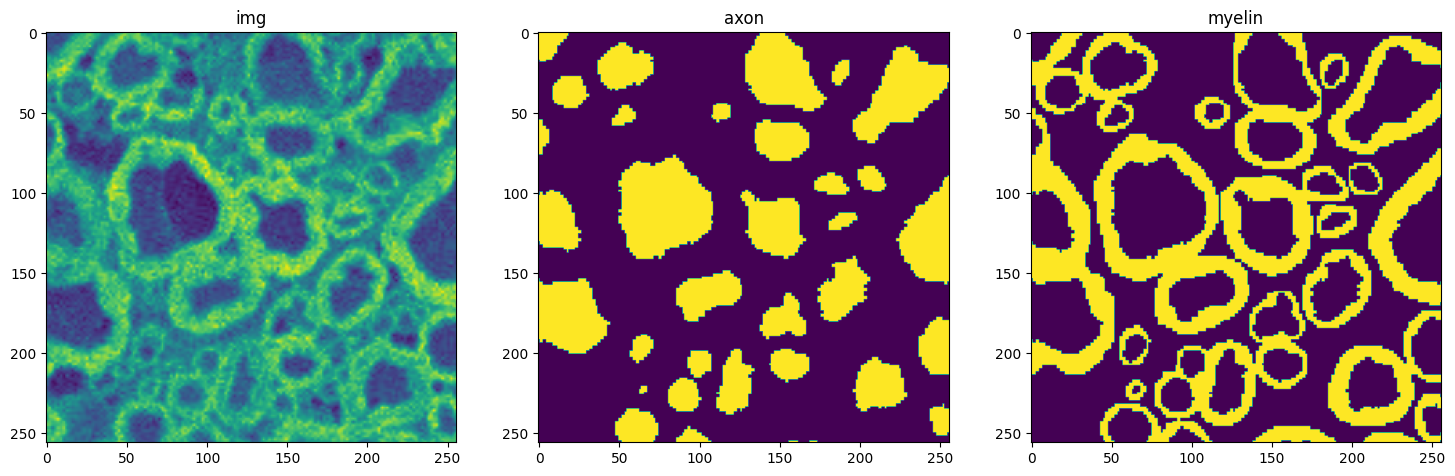

In [8]:
check_data = monai.data.Dataset(data=val_files, transform=t_resample)

patch_iterator = monai.data.PatchIterd(keys=["im", "seg-ax", "seg-my"], patch_size=(256, 256), mode='constant')
bs = 4
# need num_worker=0 in dataloader for GPU
nw = 0

check_ds = monai.data.GridPatchDataset(data=check_data, patch_iter=patch_iterator)
check_loader = DataLoader(check_ds, batch_size=bs, num_workers=nw, collate_fn=list_data_collate)

print("First patch with resampling")
for batch in check_loader:
    stuff = batch[0]
    print(stuff["im"].shape)
    for i in range(stuff["im"].shape[0]):
        plt.figure("alignment check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("img")
        plt.imshow(stuff["im"][i][0])
        plt.subplot(1, 3, 2)
        plt.title("axon")
        plt.imshow(stuff["seg-ax"][i][0])
        plt.subplot(1, 3, 3)
        plt.title("myelin")
        plt.imshow(stuff["seg-my"][i][0])
        plt.show()
        break
    break

Given the distribution of pixel sizes across the data splits for our SEM dataset, resampling will increase the amount of patches for validation and testing while decreasing the amount of training patches.

## Putting everything together
We use `RandAffineD` and `Rand2DElasticD` for data augmentation during training. The image intensity is normalized with `NormalizeIntensiryD` and the labels are discretized with `AsDiscreteD`.

In [17]:
# define transforms
train_transforms = Compose(
    [
        LoadImaged(keys=["im", "seg-ax", "seg-my"]),
        EnsureChannelFirstd(keys=["im", "seg-ax", "seg-my"]),
        NormalizeIntensityd(keys="im"),
        # resampling to 0.1 um/px
        Lambda(func=AssignPixelSize(keys=["im", "seg-ax", "seg-my"], px_size_key="px_size")),
        SpacingD(
            keys=["im", "seg-ax", "seg-my"], 
            pixdim=(0.1, 0.1),
            mode=("bilinear", "nearest", "nearest"),
        ),
        # affine and elastic transforms: adapted from ADS default-SEM-model
        # see https://github.com/axondeepseg/default-SEM-model
        RandAffined(
            keys=["im", "seg-ax", "seg-my"], 
            prob=1.0, 
            rotate_range=np.pi/64, 
            scale_range=0.05,
            translate_range=(10, 10),
            padding_mode="zeros",
            mode=("bilinear", "nearest", "nearest"),
            device=device
        ),
        Rand2DElasticd(
            keys=["im", "seg-ax", "seg-my"],
            prob=0.5,
            spacing=(30, 30),
            magnitude_range=(1, 2),
            padding_mode="zeros",
            mode=("bilinear", "nearest", "nearest"),
            device=device,
        ),
        AsDiscreted(keys=["seg-ax", "seg-my"], threshold=127)
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["im", "seg-ax", "seg-my"]),
        EnsureChannelFirstd(keys=["im", "seg-ax", "seg-my"]),
        NormalizeIntensityd(keys="im"),
        Lambda(func=AssignPixelSize(keys=["im", "seg-ax", "seg-my"], px_size_key="px_size")),
        SpacingD(
            keys=["im", "seg-ax", "seg-my"], 
            pixdim=(0.1, 0.1),
            mode=("bilinear", "nearest", "nearest"),
        ),
        AsDiscreted(keys=["seg-ax", "seg-my"], threshold=127)
    ]
)

0.093
torch.Size([4, 1, 256, 256])


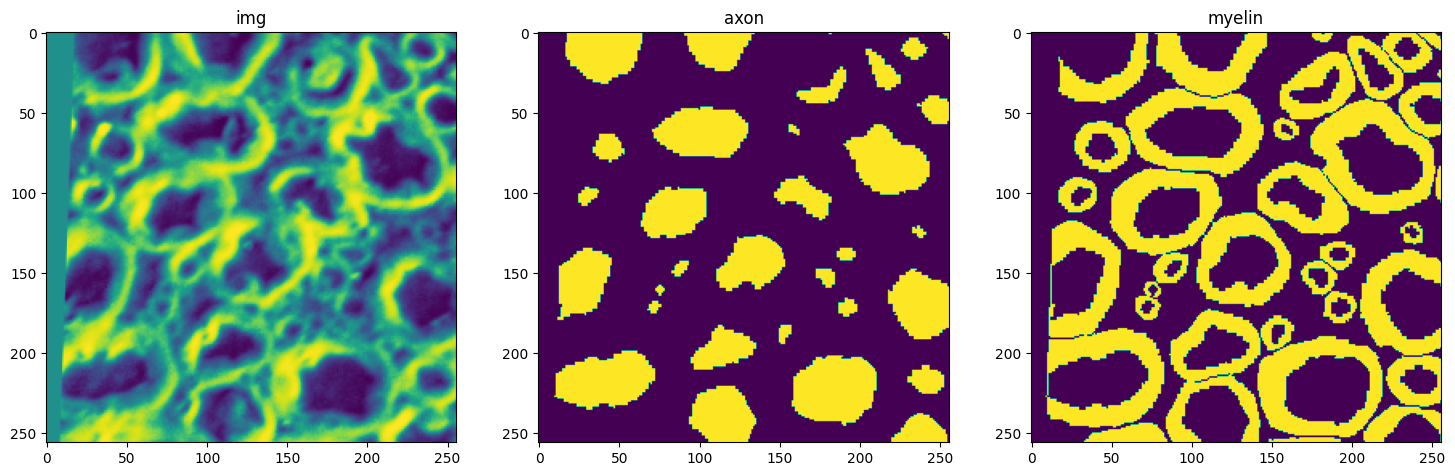

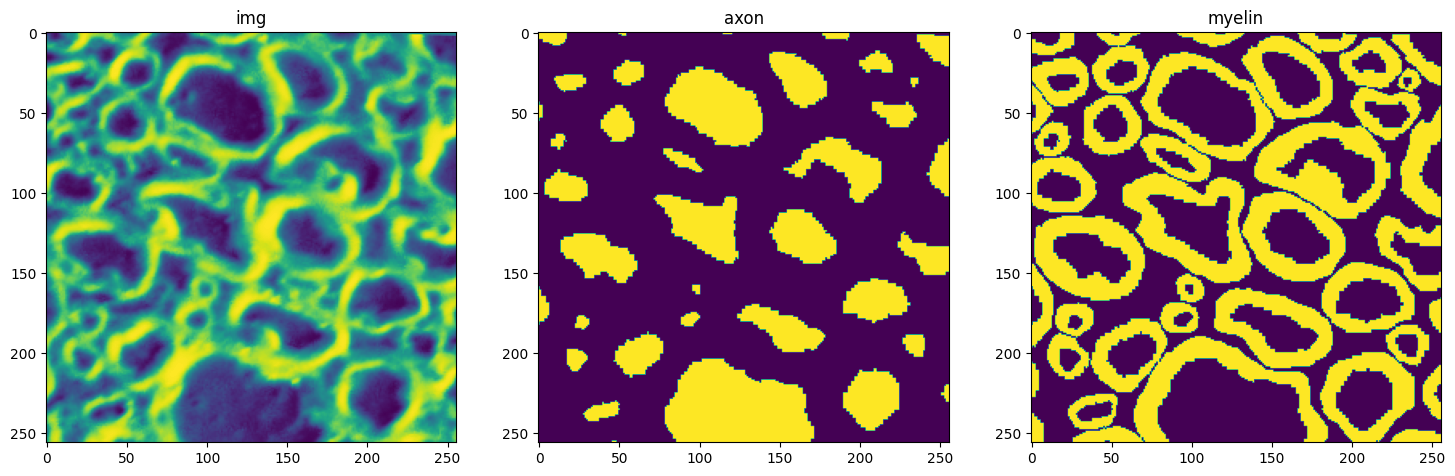

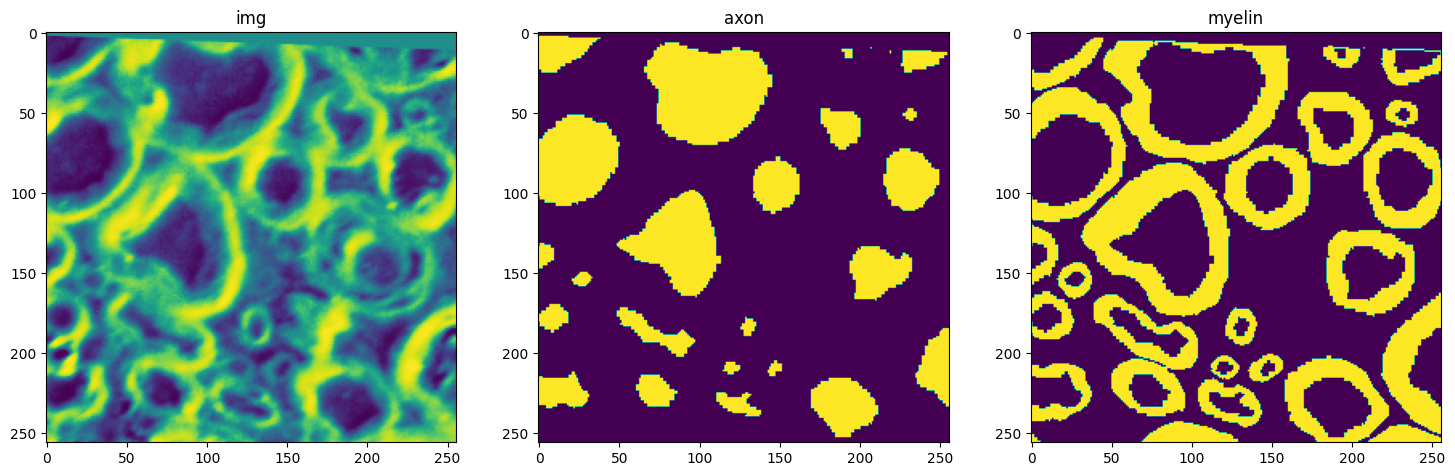

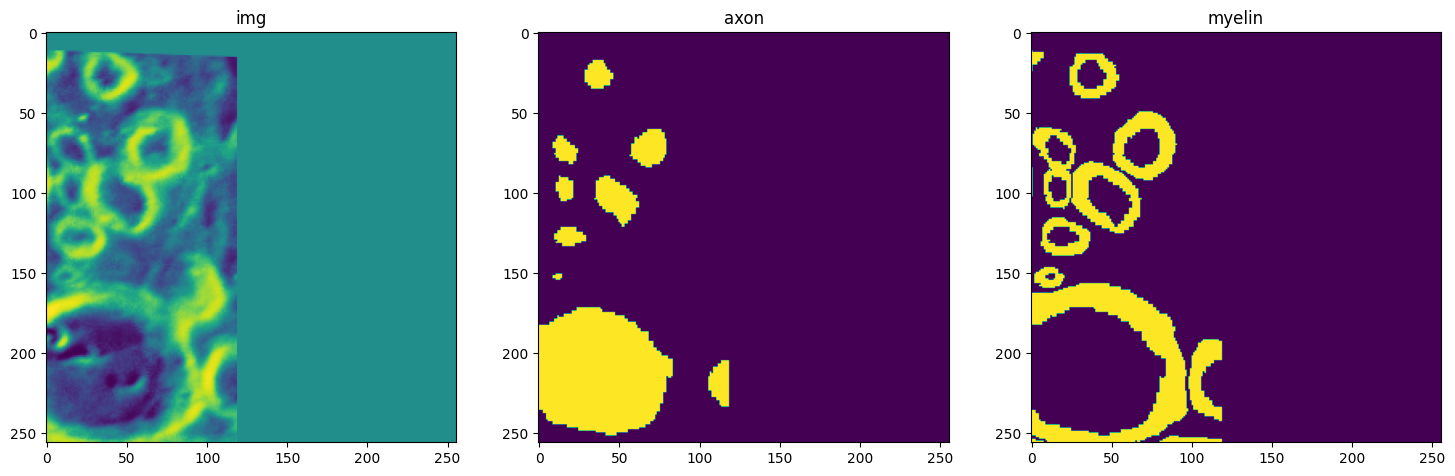

In [18]:
# first, load the images
train_data = monai.data.Dataset(data=train_files, transform=train_transforms)
val_data = monai.data.Dataset(data=val_files, transform=val_transforms)

# note that we need a GridPatchDataset instead of a Dataset to stack the patches
# otherwise, the vanilla Dataset class does not support different image sizes
# (which is often the case for microscopy data)
patch_iterator = monai.data.PatchIterd(keys=["im", "seg-ax", "seg-my"], patch_size=(256, 256), mode='constant')
bs = 4
# need num_worker=0 in dataloader for GPU
nw = 0

check_ds = monai.data.GridPatchDataset(data=train_data, patch_iter=patch_iterator)
check_loader = DataLoader(check_ds, batch_size=bs, num_workers=nw, collate_fn=list_data_collate)

for batch in check_loader:
    stuff = batch[0]
    print(stuff["im"].shape)
    for i in range(stuff["im"].shape[0]):
        plt.figure("alignment check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("img")
        plt.imshow(stuff["im"][i][0])
        plt.subplot(1, 3, 2)
        plt.title("axon")
        plt.imshow(stuff["seg-ax"][i][0])
        plt.subplot(1, 3, 3)
        plt.title("myelin")
        plt.imshow(stuff["seg-my"][i][0])
        plt.show()
    break

0.18
torch.Size([4, 1, 256, 256])


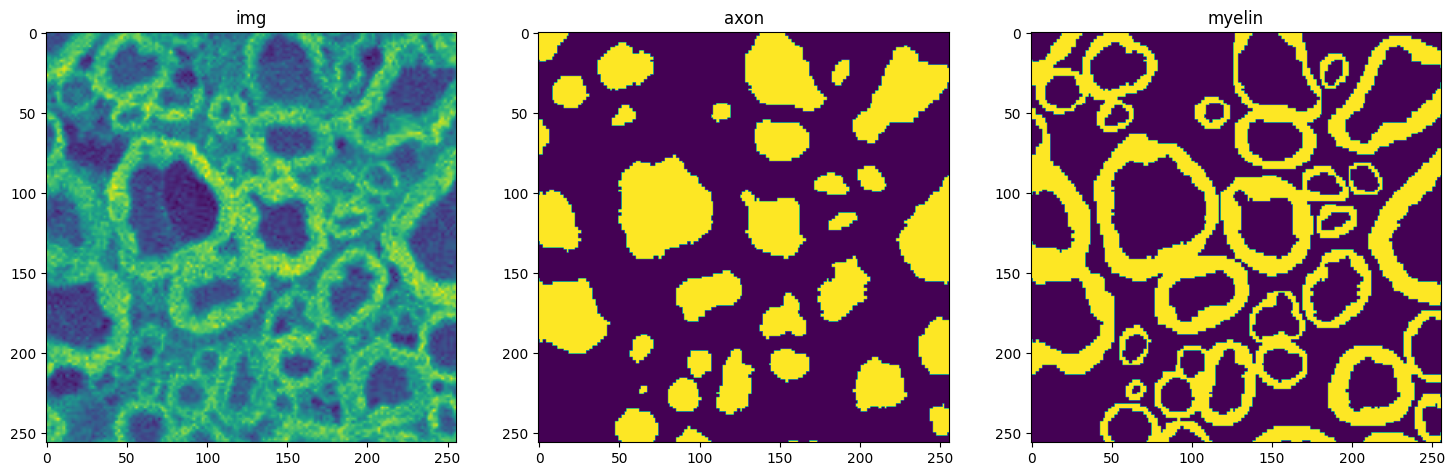

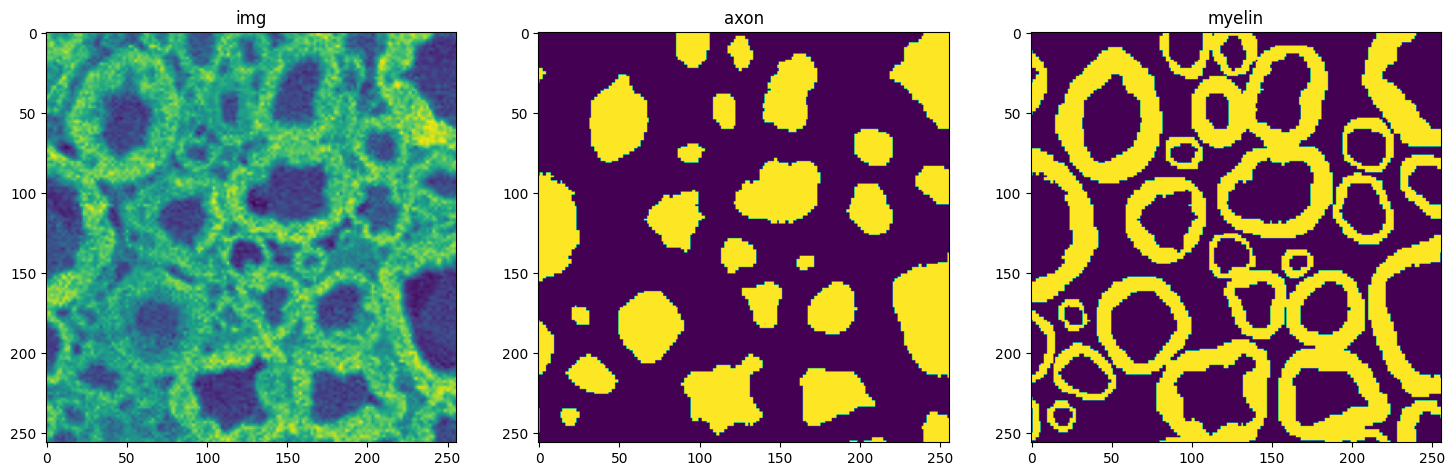

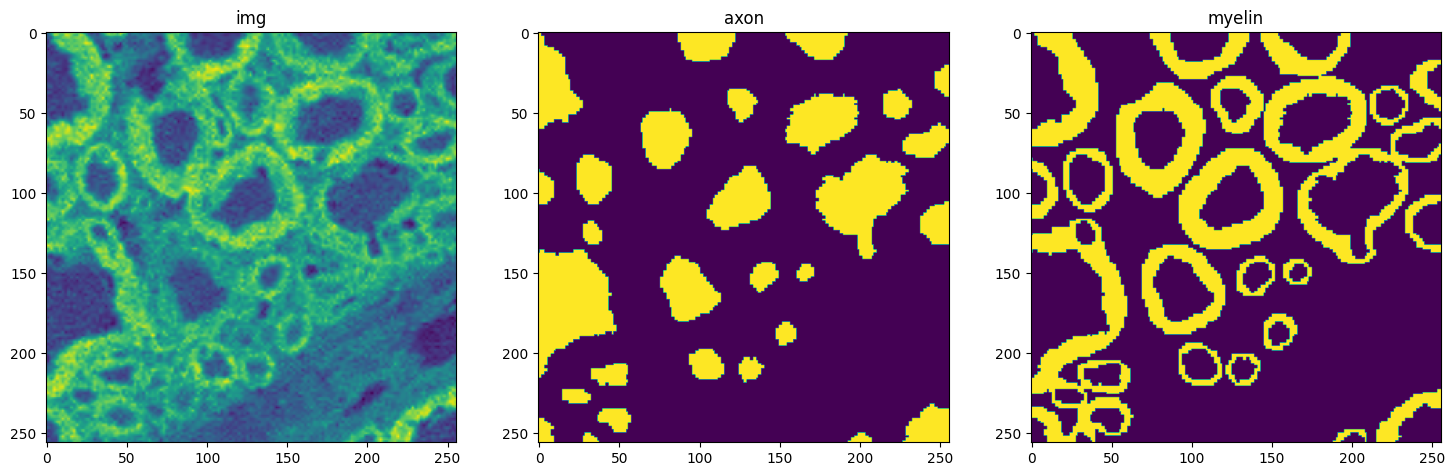

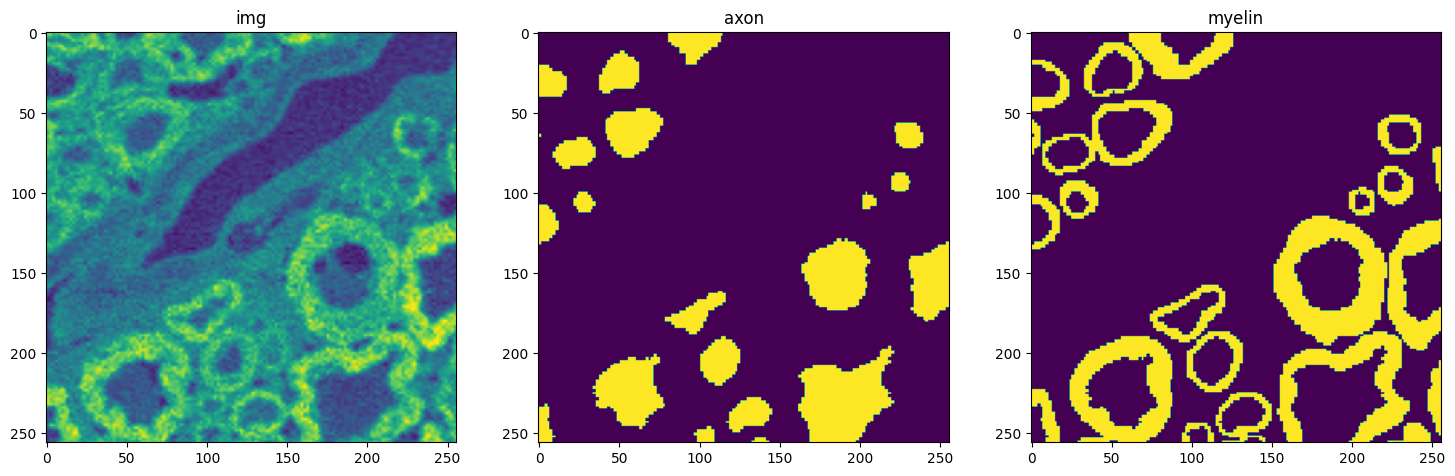

In [19]:
# check validation data and post transforms

# validation data loader
val_ds = monai.data.GridPatchDataset(data=val_data, patch_iter=patch_iterator)
val_loader = DataLoader(val_ds, batch_size=bs, num_workers=nw, collate_fn=list_data_collate)

for batch in val_loader:
    stuff = batch[0]
    print(stuff["im"].shape)
    for i in range(stuff["im"].shape[0]):
        plt.figure("alignment check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title("img")
        plt.imshow(stuff["im"][i][0])
        plt.subplot(1, 3, 2)
        plt.title("axon")
        plt.imshow(stuff["seg-ax"][i][0])
        plt.subplot(1, 3, 3)
        plt.title("myelin")
        plt.imshow(stuff["seg-my"][i][0])
        plt.show()
    break